# Import libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

# Data Cleaning and Feature Engineering

In [3]:
baseball = pd.read_csv('baseball_players.csv')

We are going to drop the first column because it is a counter for which team we pulled the information from.

In [5]:
baseball.drop(['Unnamed: 0'],inplace=True,axis=1)

We are going to drop team_ID as well because there are thirty teams and this is too many to one-hot encode this.

In [6]:
baseball.drop(['team_ID'],inplace=True,axis=1)

In order to hold the assumption of no two variables being collinear, we are going to drop onbase_plus_slugging because it is the addition of onbase_perc and slugging_perc, so we would not gain any new insight from that.

In [7]:
baseball.drop(['onbase_plus_slugging'],inplace=True,axis=1)

I am going to write a function that creates a boolean tag to see if the player has played more than one position throughout the season.

In [8]:
def position_change(position):
    position = position.replace('/','').replace('*','')
    if len(position) > 1:
        return 1
    else:
        return 0

In [9]:
baseball['played_multiple_positions'] = baseball.Pos.apply(position_change)

In [10]:
#we can now drop the Pos column 
baseball.drop(['Pos'],inplace=True,axis=1)

In [11]:
#these four functions create booleans that represents if a player won a particular award in the season
def all_star_season(awards):
    awards = str(awards)
    if 'AS' in awards:
        return 1
    else:
        return 0

def silver_slugger_season(awards):
    awards = str(awards)
    if 'SS' in awards:
        return 1
    else:
        return 0
    
def golden_glove_season(awards):
    awards = str(awards)
    if 'GG' in awards:
        return 1
    else:
        return 0

def most_valuable_season(awards):
    awards = str(awards)
    if 'MVP' in awards:
        return 1
    else:
        return 0

    

In [12]:
#applying the four above functions and creating a new column for each
baseball['is_all_star'] = baseball.awards.apply(all_star_season)
baseball['is_silver_slugger'] = baseball.awards.apply(all_star_season)
baseball['is_golden_glove'] = baseball.awards.apply(all_star_season)
baseball['is_MVP_votes'] = baseball.awards.apply(all_star_season)

In [13]:
baseball.drop(['awards'],inplace=True,axis=1)

The next step is transforming the salary column so that it represents integers

In [14]:
baseball = baseball[baseball['Salary'].notna()]
baseball['Salary'] = baseball['Salary'].str.replace('$','').str.replace(',','').astype(int)

In [15]:
#this function changes columns that are a percentage to a decimal
def percentage_changer(column):
    column = str(column)
    column = column.replace('%','')
    column = float(column)
    column = column*.01
    return column

In [16]:
baseball['adv_bat_home_run_perc'] = baseball['adv_bat_home_run_perc'].apply(percentage_changer)
baseball['adv_bat_home_run_perc'] = baseball['adv_bat_home_run_perc'].apply(percentage_changer)
baseball['adv_bat_strikeout_perc'] = baseball['adv_bat_strikeout_perc'].apply(percentage_changer)
baseball['adv_bat_base_on_balls_perc'] = baseball['adv_bat_base_on_balls_perc'].apply(percentage_changer)
baseball['adv_bat_hard_hit_perc'] = baseball['adv_bat_hard_hit_perc'].apply(percentage_changer)
baseball['adv_bat_ld_perc'] = baseball['adv_bat_ld_perc'].apply(percentage_changer)
baseball['adv_bat_gb_perc'] = baseball['adv_bat_gb_perc'].apply(percentage_changer)
baseball['adv_bat_fb_perc'] = baseball['adv_bat_fb_perc'].apply(percentage_changer)
baseball['adv_bat_pull_perc'] = baseball['adv_bat_pull_perc'].apply(percentage_changer)
baseball['adv_bat_cent_perc'] = baseball['adv_bat_cent_perc'].apply(percentage_changer)
baseball['adv_bat_oppo_perc'] = baseball['adv_bat_oppo_perc'].apply(percentage_changer)
baseball['adv_bat_cwpa_bat'] = baseball['adv_bat_cwpa_bat'].apply(percentage_changer)

The next step is to check for missing values.

In [17]:
baseball.isna().sum().sort_values(ascending=False)

adv_bat_exit_velo        442
adv_bat_hard_hit_perc    442
adv_bat_gb_fb_ratio        3
onbase_perc                2
slugging_perc              2
                        ... 
waa_win_perc_162           0
waa_win_perc               0
runs_above_rep             0
is_golden_glove            0
year                       0
Length: 64, dtype: int64

In [18]:
#Drop the columns that have a large amount of missing values
baseball.drop(['adv_bat_exit_velo','adv_bat_hard_hit_perc'],axis=1,inplace=True)

# EDA

First, let's look at one feature(Batting Average) vs. our target variable(Salary).

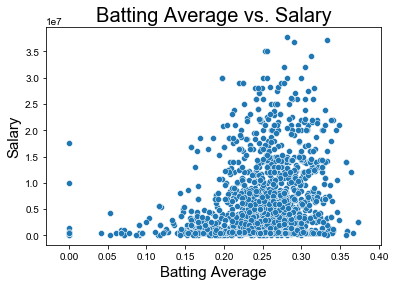

In [19]:
sns.scatterplot(x=baseball['batting_avg'],y=baseball['Salary'])
plt.title('Batting Average vs. Salary',fontsize=20)
sns.set_style('darkgrid')
plt.xlabel('Batting Average',fontsize=15)
plt.ylabel('Salary',fontsize=15)
plt.savefig('Batting_Average.png',bbox_inches='tight')

Let's look at the datapoint that has a batting average of zero but has a salary of 17,600,000.

In [324]:
baseball[(baseball['batting_avg'] == 0) & (baseball['Salary'] == 17600000)]

year  age  games  PA  AB  R  H  2B  3B  HR  ...  adv_bat_cent_perc  \
149  2016   29      3   7   6  0  0   0   0   0  ...                0.5   

     adv_bat_oppo_perc  adv_bat_wpa_bat  adv_bat_cwpa_bat  adv_bat_re24_bat  \
149                0.0             -0.1            -0.001              -1.2   

     played_multiple_positions  is_all_star  is_silver_slugger  \
149                          1            0                  0   

     is_golden_glove  is_MVP_votes  
149                0             0  

[1 rows x 62 columns]

We see that the batter has only played in three games and that is the reason he does not have any hits. This is most likely caused by an injury. PLayers that experience injuries this early in the season are going to appear as outliers because their salary will be based off of previous seasons where their production is much higher. In order to combat this, we will remove all data points where they have played less than 30 games.

In [20]:
#picking the features to use
features = baseball[['year','age','games','adv_bat_cwpa_bat','batting_avg','slugging_perc','GIDP','IBB','WAR','Rbat+','adv_bat_fb_perc','adv_bat_pull_perc','adv_bat_cent_perc','adv_bat_oppo_perc','onbase_perc','Salary']]
#filtering out the rows where they have played less than 30 games
features = baseball[baseball['batting_avg'] != 0]
features = baseball[baseball['games'] > 30]
#target will be the Salary
target = features['Salary']
features.drop(['Salary'],inplace=True, axis=1)


# Split into train, val, and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=13)

# Building the Model

We see two columns that have a large amount of missing values while other columns only have a few values. We are going to drop the two columns that have a large amount of missing values and then impute the mean for the rest.

In [21]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [22]:
#impute missing values into the data
X_train = imputer.transform(X_train)

In [23]:
#scale the data using the standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

Let's fit a basic linear regression so that we have a baseline.

In [399]:
#Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))
lr.score(X_train,np.log(y_train))

0.5464546012041043

Now lets add polynomial feautures into our data to see if we achieve a higher value of R^2.

In [416]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

lr_poly = LassoCV()
lr_poly.fit(X_train_poly,np.log(y_train))
lr_poly.score(X_train_poly,np.log(y_train))

0.6306757831523062

In [407]:
from  sklearn.model_selection import cross_val_score

#we are using a cross-validation technique to split the data into 5 sections
print(np.mean(cross_val_score(lr_poly,X_train_poly,np.log(y_train),cv=5)))
print(np.mean(cross_val_score(lr,X_train,np.log(y_train),cv=5)))

-5.476490952533909
0.5136505045542361


Let's look at the coeffecients associated with each feature in the polynomial dataset.

In [371]:
list(zip(poly.get_feature_names(),lr_poly.coef_))

[('1', 0.0),
 ('x0', 883085.0383826103),
 ('x1', 2825372.9907117905),
 ('x2', -1273242.5080522725),
 ('x3', 1983677.9348674319),
 ('x4', 0.0),
 ('x5', -69199.3176210789),
 ('x6', 0.0),
 ('x7', 0.0),
 ('x8', 918798.6252488511),
 ('x9', 1273720.6702342473),
 ('x10', -0.0),
 ('x11', 0.0),
 ('x12', 126880.10990353485),
 ('x13', 66670.40475650113),
 ('x14', -31238.359298657106),
 ('x15', -0.0),
 ('x16', -0.0),
 ('x0^2', 221720.53942439158),
 ('x0 x1', 234472.39318710653),
 ('x0 x2', -292615.01263424224),
 ('x0 x3', 0.0),
 ('x0 x4', -0.0),
 ('x0 x5', 0.0),
 ('x0 x6', 0.0),
 ('x0 x7', 151184.9470892589),
 ('x0 x8', -0.0),
 ('x0 x9', 258455.73063608308),
 ('x0 x10', 279547.87901710445),
 ('x0 x11', 128581.01787335268),
 ('x0 x12', 154593.2161055123),
 ('x0 x13', -0.0),
 ('x0 x14', 45149.744995463676),
 ('x0 x15', -136308.09020889303),
 ('x0 x16', -67081.60267204834),
 ('x1^2', 0.0),
 ('x1 x2', -0.0),
 ('x1 x3', 477302.66340523784),
 ('x1 x4', 0.0),
 ('x1 x5', -30175.285119367007),
 ('x1 x6', -

We are going to use only colunms that have a p-value below .1

In [24]:
baseball_shortened = baseball[['year','age','games','R','2B','3B','batting_avg','slugging_perc','GIDP','IBB','WAA','WAR','Rbat+','adv_bat_fb_perc','adv_bat_pull_perc','adv_bat_cent_perc','adv_bat_oppo_perc','played_multiple_positions','Salary']]
new = baseball_shortened[baseball_shortened['batting_avg'] != 0]

In [25]:
new = baseball_shortened[baseball_shortened['games'] > 30]
target = new['Salary']
features = new.drop(['Salary'],axis=1)

# Split into train, val, and test
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=13)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_val = imputer.transform(X_val)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

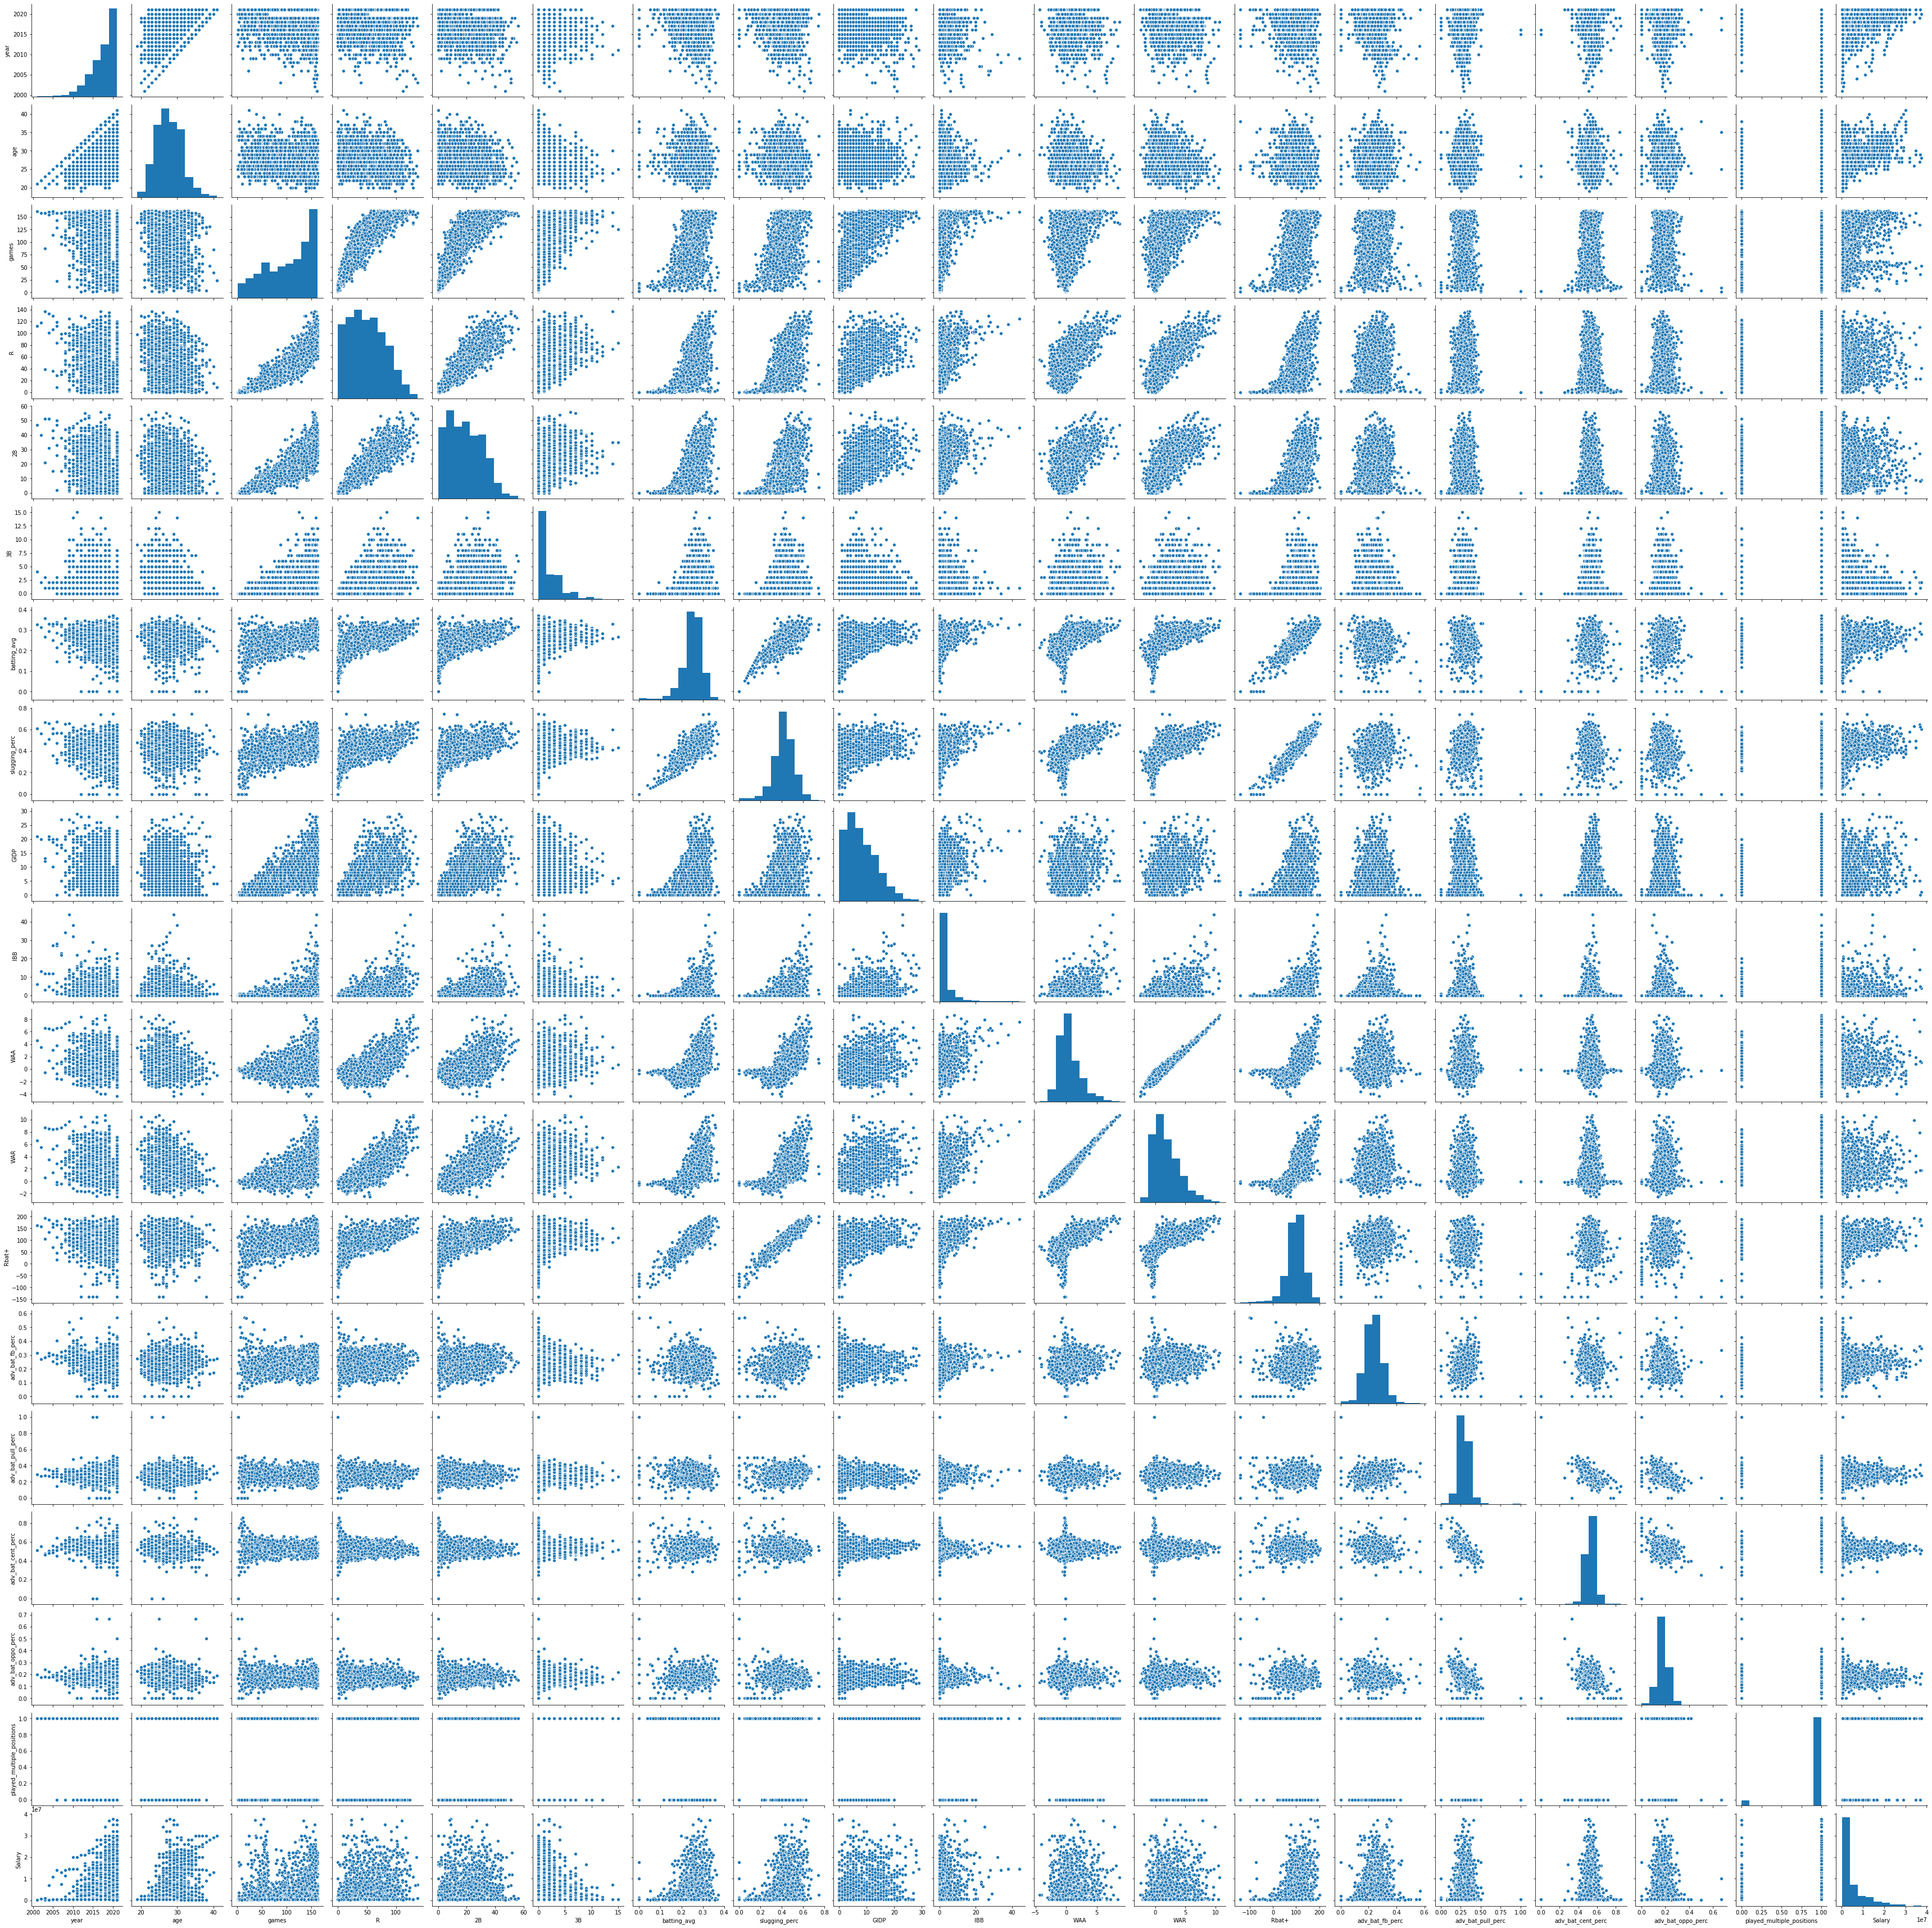

In [131]:
sns.pairplot(baseball_shortened)

The first thing we notice from these pair plots is that WAA and WAR are highly correlated. We will remove WAA to hold closer to the linear regression assumption of linearity.

In [132]:
baseball_shortened.drop(['WAA'],axis=1,inplace=True)

I am also seeing a few points where batting average is zero but a salary is listed, so I will look into that next.

In [134]:
baseball_shortened[baseball_shortened['batting_avg'] == 0]

year  age  games  R  2B  3B  batting_avg  slugging_perc  GIDP  IBB  WAR  \
130   2012   27     18  0   0   0          0.0            0.0     0    0 -0.6   
149   2016   29      3  0   0   0          0.0            0.0     0    0 -0.2   
174   2021   27     15  1   0   0          0.0            0.0     0    0 -0.4   
206   2021   38      3  0   0   0          0.0            0.0     0    0 -0.2   
695   2016   23      2  0   0   0          0.0            0.0     0    0 -0.1   
989   2015   26      1  0   0   0          0.0            0.0     0    0 -0.2   
1040  2021   36      6  1   0   0          0.0            0.0     0    0 -0.3   
1263  2012   25      1  0   0   0          0.0            0.0     0    0 -0.1   
1675  2012   27     18  0   0   0          0.0            0.0     0    0 -0.6   
1730  2016   25      1  0   0   0          0.0            0.0     0    0 -0.1   
2389  2016   23      2  0   0   0          0.0            0.0     0    0 -0.1   
3065  2019   26      9  1   0   0          0.0            0.0     0    0 -0.2   
3132  2014   26      9  0   0   0          0.0            0.0     1    0 -0.3   
3841  2019   35      9  0   0   0          0.0            0.0     0    0  NaN   

      Rbat+  adv_bat_fb_perc  adv_bat_pull_perc  adv_bat_cent_perc  \
130   -95.0            0.565              0.261              0.609   
149   -73.0            0.000              0.500              0.500   
174   -85.0            0.200              0.400              0.400   
206  -140.0            0.250              0.250              0.250   
695   -41.0            0.000              1.000              0.000   
989  -140.0            0.000              1.000              0.000   
1040  -57.0            0.167              0.333              0.333   
1263 -140.0            0.000              0.500              0.500   
1675  -95.0            0.565              0.261              0.609   
1730 -140.0            0.000              0.000              0.333   
2389  -41.0            0.000              1.000              0.000   
3065  -56.0            0.000              0.167              0.500   
3132 -141.0            0.286              0.286              0.429   
3841  -71.0            0.333              0.000              0.333   

      adv_bat_oppo_perc  played_multiple_positions    Salary  
130               0.130                          1    480000  
149               0.000                          1  17600000  
174               0.200                          1   1360000  
206               0.500                          0    100000  
695               0.000                          0    522000  
989               0.000                          0    554100  
1040              0.333                          1    100000  
1263              0.000                          1    480425  
1675              0.130                          1    480000  
1730              0.667                          0    510000  
2389              0.000                          0    522000  
3065              0.333                          1    561200  
3132              0.286                          1    510000  
3841              0.667                          0  10000000

No other variables seem highly correlated with salary, so I am going to add polynomial terms as well.

# Final Tests

In [417]:
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)
X_test_poly = poly.transform(X_test)


In [418]:
lr_poly.score(X_test_poly,np.log(y_test))

0.5625614615988594

In [423]:
mean_squared_error(lr_poly.predict(X_test_poly),np.log(y_test),squared=False)

0.9083964111171072

In [424]:
np.exp(0.9083964111171072)

2.480341893896393